# CIV1498 Team Project 2

## Simple linear model for trips demand

Understand the demand for bike-sharing after Covid-19.

1.What variables are meaningful in predicting the demand for bike sharing
2.How well these variables describe the demand for bike sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

## Data input

In [2]:
df=pd.read_csv('trips_with_coordinates_distance_weather.csv')

In [3]:
df.shape

(10173316, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10173316 entries, 0 to 10173315
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Start Time           object 
 1   End Time             object 
 2   Trip Duration        int64  
 3   Start Station Id     float64
 4   Start Station Name   object 
 5   End Station Id       float64
 6   End Station Name     object 
 7   User Type            object 
 8   Start_Lat            float64
 9   Start_Lon            float64
 10  End_Lat              float64
 11  End_Lon              float64
 12  Distance             float64
 13  merge_time           object 
 14  Longitude (x)        float64
 15  Latitude (y)         float64
 16  Station Name         object 
 17  Climate ID           float64
 18  Date/Time            object 
 19  Year                 float64
 20  Month                float64
 21  Day                  float64
 22  Time                 object 
 23  Temp (°C)            float64
 

In [5]:
df.head()

,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Start_Lat,Start_Lon,...,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
0,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual Member,43.660439,-79.385525,...,1.0,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,sunny_day
1,2017-01-05 18:06:00-05:00,2017-01-05 18:11:00-05:00,252,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual Member,43.660439,-79.385525,...,5.0,18:00,-6.8,-12.9,62.0,27.0,30.0,16.1,100.21,sunny_day
2,2017-01-06 18:46:00-05:00,2017-01-06 18:50:00-05:00,241,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual Member,43.660439,-79.385525,...,6.0,19:00,-9.3,-16.9,55.0,29.0,17.0,16.1,101.48,sunny_day
3,2017-01-09 19:17:00-05:00,2017-01-09 19:21:00-05:00,262,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual Member,43.660439,-79.385525,...,9.0,19:00,-2.6,-7.9,67.0,24.0,28.0,16.1,101.91,sunny_day
4,2017-01-10 17:37:00-05:00,2017-01-10 17:42:00-05:00,285,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual Member,43.660439,-79.385525,...,10.0,18:00,3.2,2.3,94.0,16.0,21.0,11.3,99.70,Moderate Rain


In [6]:
# replace the weather condition to 3 level good weather 1 medium 2 very bad 3
df['Weather']=df['Weather'].replace(['sunny_day'],1)
df['Weather']=df['Weather'].replace(['Moderate Rain','Rain','Snow','Rain,Fog','Fog','Moderate Rain,Fog',],2)
df['Weather']=df['Weather'].replace(['Thunderstorms,Moderate Rain','Haze','Thunderstorms','Thunderstorms,Heavy Rain,Fog','Thunderstorms,Rain','Rain,Snow','Thunderstorms,Rain,Fog',
'Thunderstorms,Heavy Rain','Heavy Snow','Heavy Rain,Fog','Thunderstorms,Moderate Rain,Fog','Haze,Blowing Snow','Thunderstorms,Fog','Freezing Rain,Snow','Moderate Snow',
'Freezing Rain,Fog','Freezing Rain','Snow,Blowing Snow'],3)

In [7]:
df["Start Time"] = pd.to_datetime(df["Start Time"])
df['day'] = df['Start Time'].dt.day
df['month']=df['Start Time'].dt.month
df['year']= df['Start Time'].dt.year
df['hour'] =df['Start Time'].dt.hour

In [8]:
df = df.drop(df[df['year']<2017].index) # no weather data in 2016

In [9]:
df_group= df.groupby(pd.Grouper(key="Start Time",freq='D')).agg(trip_count=('Start Station Name',"count"),
                                                                 annual_members=('User Type',lambda x: (x == 'Annual Member').sum()),
                                                                 casual_members=('User Type',lambda x: (x == 'Casual Member').sum()),
                                                                 trip_duration=('Trip Duration',"sum"),
                                                                 trip_distance=('Distance',"sum"),
                                                                 tem=('Temp (°C)',"median"),
                                                                 dew_point_temp=('Dew Point Temp (°C)',"median"),
                                                                 wind_dir=('Wind Dir (10s deg)',"median"),
                                                                 wind_spd=('Wind Spd (km/h)',"median"),
                                                                 visibility=('Visibility (km)',"median"),
                                                                 stn_press=('Stn Press (kPa)',"median"),
                                                               weather=('Weather',"max")   )

df_group['year']=df_group.index.year
df_group['month']=df_group.index.month
df_group['dow'] = df_group.index.dayofweek
df_group=df_group.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df_group.head()

,trip_count,annual_members,casual_members,trip_duration,trip_distance,tem,dew_point_temp,wind_dir,wind_spd,visibility,stn_press,weather,year,month,dow
Start Time,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,232,194,38,205033,3.850872e+05,1.8,-4.6,23.0,18.0,16.1,101.38,1.0,2017,1,6
2017-01-02 00:00:00-05:00,399,359,40,328635,5.953085e+05,3.9,0.6,7.0,22.0,16.1,101.44,2.0,2017,1,0
2017-01-03 00:00:00-05:00,419,412,7,281075,7.405843e+05,4.4,4.1,6.0,15.0,12.9,99.49,2.0,2017,1,1
2017-01-04 00:00:00-05:00,693,677,16,481177,1.134824e+06,-3.9,-10.9,26.0,46.0,16.1,99.31,2.0,2017,1,2
2017-01-05 00:00:00-05:00,558,549,9,356075,9.362941e+05,-6.8,-12.2,27.0,30.0,16.1,100.28,2.0,2017,1,3


## Visualizing Correlation

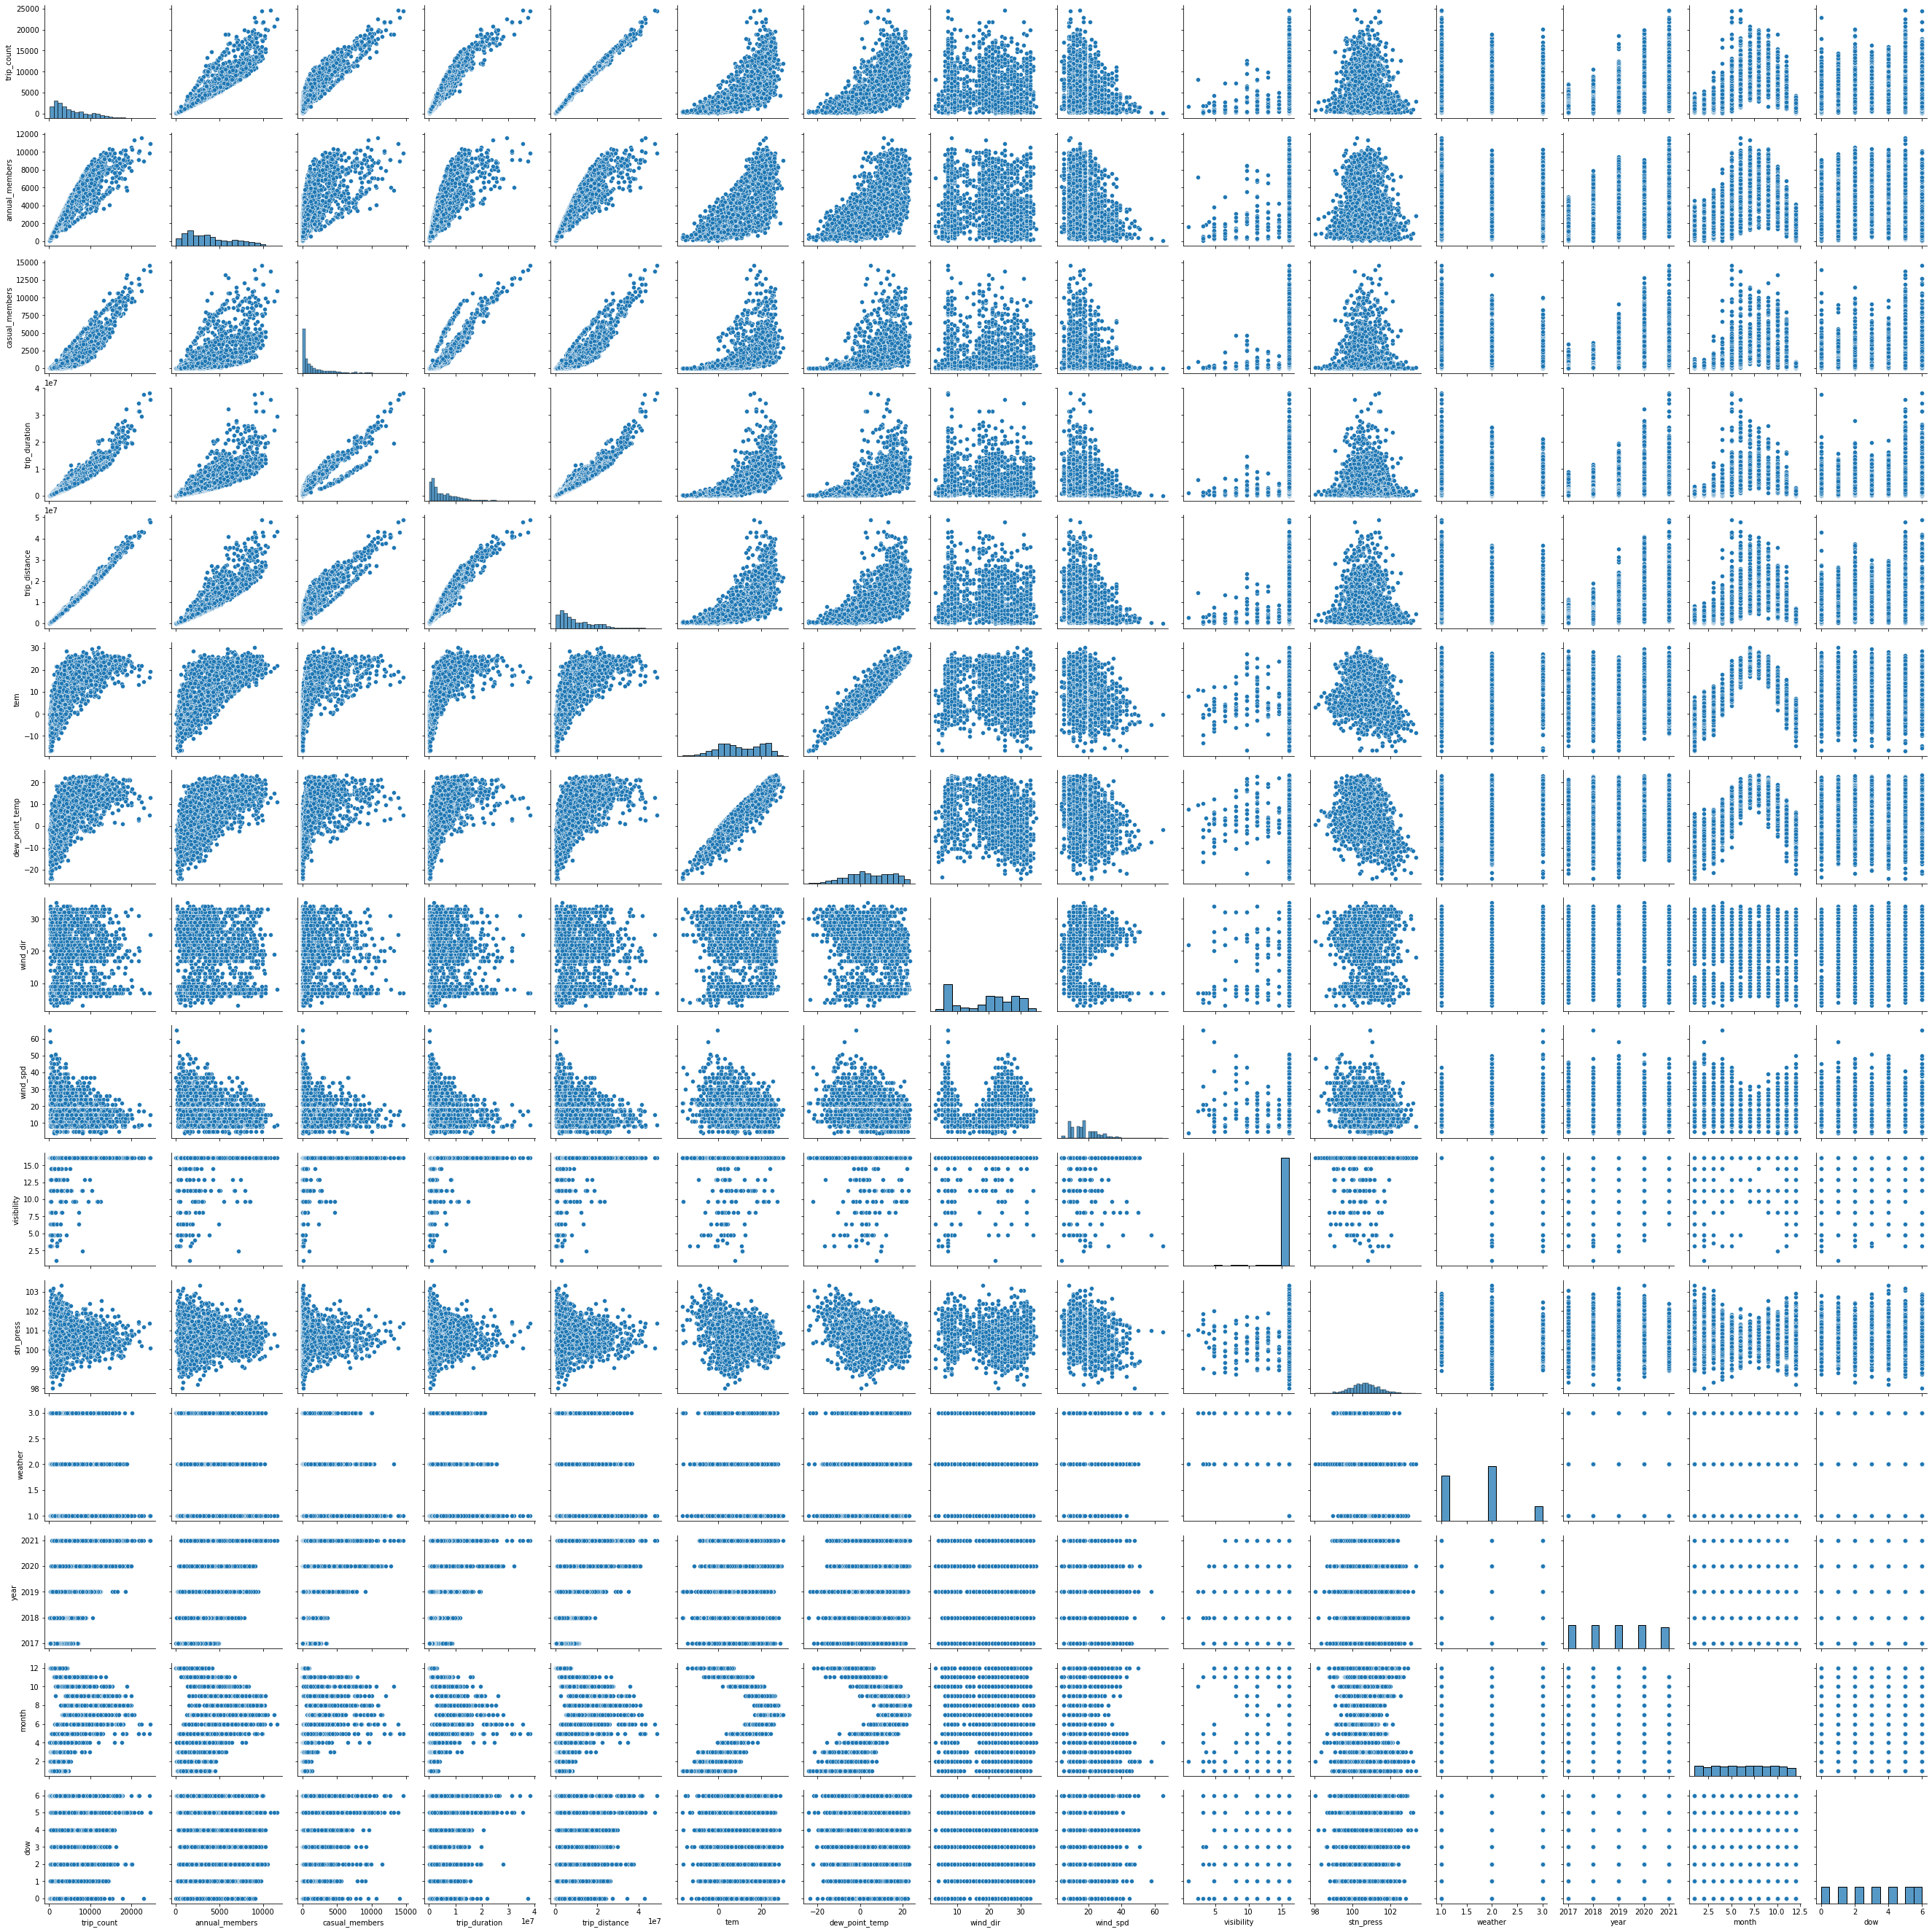

In [10]:

# pairplot
sns.pairplot(df_group)
plt.show()

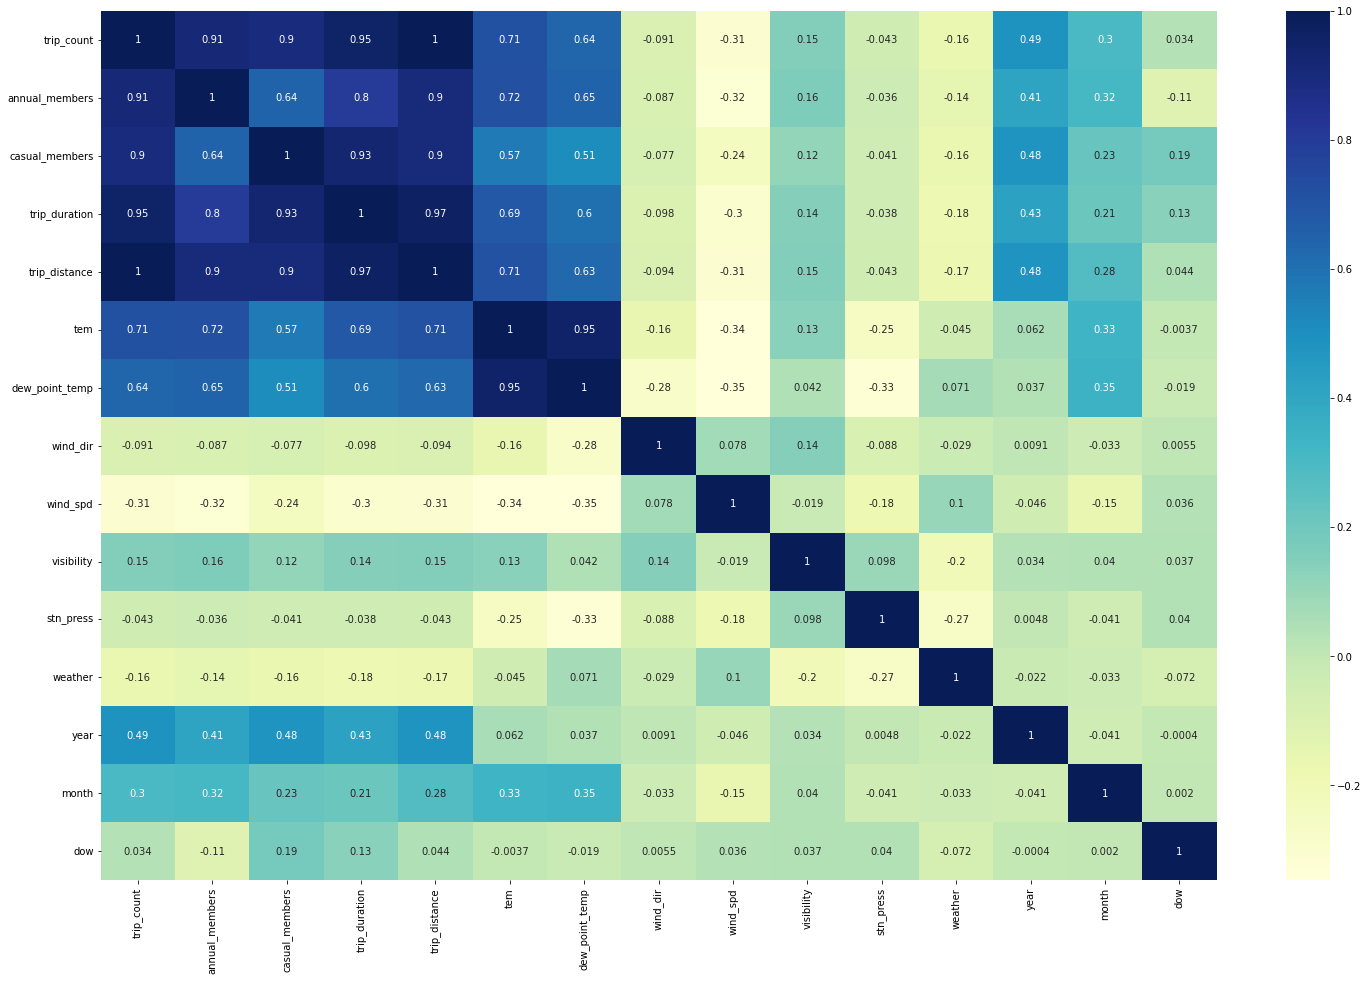

In [11]:
# Correlation Matrix
plt.figure(figsize = (25, 16))
sns.heatmap(df_group.corr(), annot = True, cmap="YlGnBu")
plt.show()

drop the 'annual_members','casual_members', 'trip_duration', 'trip_distance' for too high Correlation

In [12]:
df_group.drop(['annual_members','casual_members', 'trip_duration', 'trip_distance'], axis = 1, inplace = True)

Add dummie variable

In [13]:
dummy_1 = pd.get_dummies(df_group['weather'], prefix = 'weather', drop_first = True)   
dummy_2 = pd.get_dummies(df_group['year'], prefix = 'year', drop_first = True)
dummy_3 = pd.get_dummies(df_group['month'], prefix = 'month', drop_first = True)
dummy_4 = pd.get_dummies(df_group['dow'], prefix = 'dow', drop_first = True)

#Dropping one dummy variable to protect from the dummy variable trap.
#The Dummy Variable Trap occurs when two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear)

In [119]:
df_data=pd.concat([df_group, dummy_1, dummy_2, dummy_3, dummy_4], axis=1)
df_data.drop(['weather','year','month','dow'],axis=1,inplace=True)

In [120]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1792 entries, 2017-01-01 00:00:00-05:00 to 2021-11-30 00:00:00-05:00
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trip_count      1792 non-null   int64  
 1   tem             1792 non-null   float64
 2   dew_point_temp  1792 non-null   float64
 3   wind_dir        1792 non-null   float64
 4   wind_spd        1792 non-null   float64
 5   visibility      1792 non-null   float64
 6   stn_press       1792 non-null   float64
 7   weather_2.0     1792 non-null   uint8  
 8   weather_3.0     1792 non-null   uint8  
 9   year_2018       1792 non-null   uint8  
 10  year_2019       1792 non-null   uint8  
 11  year_2020       1792 non-null   uint8  
 12  year_2021       1792 non-null   uint8  
 13  month_2         1792 non-null   uint8  
 14  month_3         1792 non-null   uint8  
 15  month_4         1792 non-null   uint8  
 16  month_5         1792 non-null 

# Build linear Model

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vars=['tem','dew_point_temp','wind_dir','wind_spd','visibility','stn_press']
df_data[vars]=scaler.fit_transform(df_data[vars]) 

In [122]:
y= df_data.pop('trip_count')
X= df_data

Splitting the Data into Training and Testing Sets

In [123]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

Building a linear model

In [124]:
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [125]:
y_pred=lm.predict(X_test)

## Model Evaluation

In [126]:
#lm
from sklearn import metrics
mse=metrics.mean_squared_error(y_test,y_pred)
rmse=np.sqrt(metrics.mean_squared_error(y_test,y_pred))
score_lm=r2_score(y_test,y_pred)
print('MES',mse)
print('RMSE',rmse)
print('R2',score_lm)

MES 4643341.904303319
RMSE 2154.841503290513
R2 0.7708368365554416


In [127]:
from sklearn.model_selection import cross_val_predict
predicted=cross_val_predict(lm,X,y,cv=10)
cross_mse=metrics.mean_squared_error(y,predicted)
cross_rmse=np.sqrt(metrics.mean_squared_error(y,predicted))
cross_score=r2_score(y,predicted)

print('R2',cross_score)
print('CROSS_MSE',cross_mse)
print('CROSS_RMSE',cross_rmse)

R2 0.6063068393219972
CROSS_MSE 8142798.513923789
CROSS_RMSE 2853.5589207030207


## Feature Selection

Recursive Feature Elimination

In [128]:
rfe=RFE(lm,20)
rfe=rfe.fit(X_train,y_train)
top20=pd.DataFrame()
top20['features']=X_train.columns
top20['Feature Chosen'] = rfe.support_
#top20['Ranking']=rfe.ranking_
#top20.sort_values(by='Ranking')

C:\Users\Wang\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [129]:
col=X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_test_rfe = X_test[col]

In [130]:
lm1=LinearRegression()
lm1.fit(X_train_rfe,y_train)
y_pred1=lm1.predict(X_test_rfe)

In [131]:
mse=metrics.mean_squared_error(y_test,y_pred1)
rmse=np.sqrt(metrics.mean_squared_error(y_test,y_pred1))
score_lm=r2_score(y_test,y_pred1)
print('MES',mse)
print('RMSE',rmse)
print('R2',score_lm)

MES 4671140.490050044
RMSE 2161.2821403162625
R2 0.769464891094544


Check for the multicollinearity 

In [143]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [133]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif.sort_values(by = "VIF", ascending = False)

,Features,VIF
0,tem,153.637191
1,dew_point_temp,127.818378
3,stn_press,7.872800
2,wind_spd,3.532322
13,month_8,2.853347
12,month_7,2.818568
4,weather_2.0,2.659991
14,month_9,2.268994
11,month_6,2.222027
8,year_2020,2.020875


In [134]:
X_train_rfe2=X_train_rfe.drop(["tem"], axis = 1)
X_test_rfe2=X_test_rfe.drop(["tem"], axis = 1)

In [135]:
lm2=LinearRegression()
lm2.fit(X_train_rfe2,y_train)
y_pred2=lm2.predict(X_test_rfe2)

In [136]:
mse=metrics.mean_squared_error(y_test,y_pred2)
rmse=np.sqrt(metrics.mean_squared_error(y_test,y_pred2))
score_lm=r2_score(y_test,y_pred2)
print('MES',mse)
print('RMSE',rmse)
print('R2',score_lm)

MES 5064713.650488971
RMSE 2250.4918685676184
R2 0.7500408485941481


In [137]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe2.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe2.values, i) for i in range(X_train_rfe2.shape[1])]
vif.sort_values(by = "VIF", ascending = False).head()

,Features,VIF
0,dew_point_temp,18.720834
2,stn_press,7.081240
1,wind_spd,3.395048
12,month_8,2.456918
3,weather_2.0,2.440359


In [139]:
cdf=pd.DataFrame(lm2.coef_, X_train_rfe2.columns, columns=['Coefficients'])
cdf.sort_values(by = 'Coefficients',ascending = False,inplace = True)
cdf

,Coefficients
year_2021,6331.329429
dew_point_temp,5583.574304
month_8,5461.260156
month_9,4862.895151
month_7,4727.942730
month_6,4056.189670
year_2020,3997.913434
year_2019,3410.837971
month_10,2846.173590
month_5,2426.542477


In [140]:
y_train_pred=lm2.predict(X_train_rfe2)
res=y_train-y_train_pred

C:\Users\Wang\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Residuals')

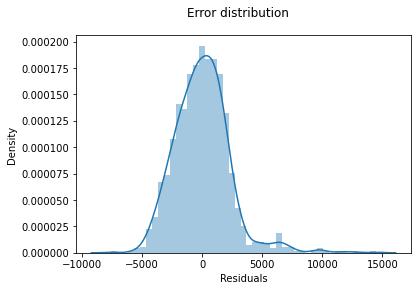

In [141]:
fig = plt.figure()
sns.distplot((res))
fig.suptitle('Error distribution')            
plt.xlabel('Residuals')   

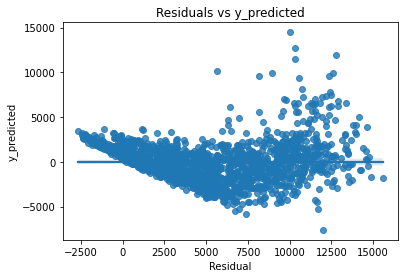

In [142]:
# Plotting Residuals 
plt.title("Residuals vs y_predicted")
sns.regplot(x=y_train_pred, y=res)
plt.xlabel("Residual")
plt.ylabel("y_predicted")
plt.show()

Conclusion

In the previous analysis, we find that most people like to bike in the afternoon and the summertime.This means there can be a correlation between weather and the number of bike trips. We hope to find a positive correlation between the number of bike shares and the temperature in the weather.

The simple multiple linear model examined the relationship between bike-share variables, including weather conditions, date, and temperature, to determine the effect on the number of total trips. We aggregated data from Toronto Bike Share from 2017 to 2021. We identify several hypotheses like the weather is a positive correlation, and as the covid continues, there is a positive impact on the number of trips. And we can find the result to prove our hypothesis that the number of trips positively correlates with the high temperature and summer months. On the opposite, the terrible weather is an inverse correlation. In addition to that in the year of Covid, the variables show a stronger correlation with the number of trips.

